## Homework №3

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext
# ! pip install spacy

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time
import gc

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [4]:
# baseline tokenizer
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

# other tokenizer
spacy_en = spacy.load('en_core_web_sm')
def tokenize_src(text):
    return WordPunctTokenizer().tokenize(text.lower())[::-1]
    #return WordPunctTokenizer().tokenize(text.lower())

def tokenize_trg(text):
    #return [tok.text for tok in spacy_en.tokenizer(text)]
    return WordPunctTokenizer().tokenize(text.lower())

In [5]:
SRC = Field(tokenize=tokenize_src,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize_trg,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [6]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [7]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9224
Unique tokens in target (en) vocabulary: 6756


Here are tokens from original (RU) corpus:

In [8]:
SRC.vocab.itos[::1000]

['<unk>',
 'моста',
 'автомагистралью',
 'лесной',
 'элегантными',
 'целый',
 'parkhotel',
 'футболом',
 'дополнительными',
 'толедо']

And from target (EN) corpus:

In [9]:
TRG.vocab.itos[::1000]

['<unk>', '36', 'community', 'canberra', 'mimosa', 'soul', 'magazines']

And here is example from train dataset:

In [10]:
print(vars(train_data.examples[11]))

{'trg': ['you', 'can', 'enjoy', 'sea', 'view', '.'], 'src': ['.', 'море', 'на', 'вид', 'открывается', 'окон', 'из']}


Let's check the length distributions:

Length distribution in Train data


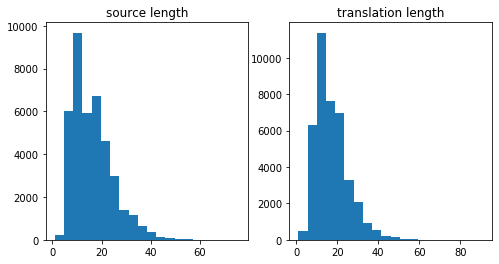

In [11]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


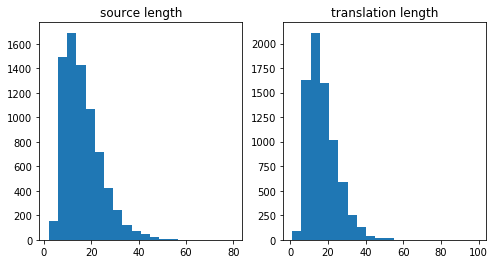

In [12]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

In [13]:
import torch
a = torch.tensor([[1,2,3],[4,5,6]])
for word_seq in a:
    print(word_seq)

tensor([1, 2, 3])
tensor([4, 5, 6])


### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [15]:
from utils import *
from routine import train_model


INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
# for position encoding
MAX_LENGTH_INPUT_SENTENCES = max(map(len, [vars(x)['src'] for x in dataset.examples]))
MAX_LENGTH_OUTPUT_SENTENCES = max(map(len, [vars(x)['trg'] for x in dataset.examples]))

BATCH_SIZE = 120

PAD_IDX = TRG.vocab.stoi['<pad>']

In [16]:
def _len_sort_key(x):
    return len(x.src)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 120]
	[.trg]:[torch.cuda.LongTensor of size 41x120 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 42x120 (GPU 0)]
torch.Size([42, 120]) torch.Size([41, 120])


#### LSTMx2 LSTMx2 (Baseline model)

#### LSTMx2 LSTMx2 with Attention (Baseline model + Attention)

#### LSTMx2 LSTMx2 with Attention and positional encoding (Baseline model + Attention + PE)

In [17]:
import nmt_lstmAttentionPE 

encoder_attpe = nmt_lstmAttentionPE.Encoder(INPUT_DIM, ENC_EMB_DIM, MAX_LENGTH_INPUT_SENTENCES, BATCH_SIZE, HID_DIM, N_LAYERS, ENC_DROPOUT, device)
decoder_attpe = nmt_lstmAttentionPE.Decoder(OUTPUT_DIM, DEC_EMB_DIM, MAX_LENGTH_OUTPUT_SENTENCES, BATCH_SIZE, HID_DIM, N_LAYERS, DEC_DROPOUT, device)

# dont forget to put the model to the right device
model_attpe = nmt_lstmAttentionPE.Seq2Seq(encoder_attpe, decoder_attpe, device).to(device)
model_attpe.apply(init_weights)

print(f'The model has {count_parameters(model_attpe):,} trainable parameters')

optimizer_attpe = optim.Adam(model_attpe.parameters(), lr=1e-3)
scheduler_attpe = ReduceLROnPlateau(optimizer_attpe, mode='min', factor=0.3, patience=2)
criterion_attpe = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

C:\Users\Lisen\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Lisen\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


The model has 15,746,404 trainable parameters


In [18]:
#import nmt_cnnlstm

#Encoder_cnn = nmt_cnnlstm.Encoder
#Decoder_cnn = nmt_cnnlstm.Decoder
#Seq2Seq_cnn = nmt_cnnlstm.Seq2Seq

#enc_cnn = Encoder_cnn(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
#dec_cnn = Decoder_cnn(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
#model_cnn = Seq2Seq_cnn(enc_cnn, dec_cnn, device).to(device)

#model_cnn.apply(init_weights)
#print(f'The model has {count_parameters(model_cnn):,} trainable parameters')

#PAD_IDX = TRG.vocab.stoi['<pad>']
#optimizer_cnn = optim.Adam(model_cnn.parameters())
#criterion_cnn = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [19]:
#model = train_model(model, {"train":train_iterator,"valid":valid_iterator}, optimizer, criterion, scheduler, n_epochs=20,  clip=1, show_plots=True, nameModel="nmt_lstm.pth")
torch.cuda.empty_cache()
gc.collect()

14309

In [20]:
#model_att = train_model(model_att, {"train":train_iterator,"valid":valid_iterator}, optimizer_att, criterion_att,scheduler_att, n_epochs=15,  clip=1, show_plots=True, nameModel="nmt_lstmAttention.pth")
torch.cuda.empty_cache()
gc.collect()

20

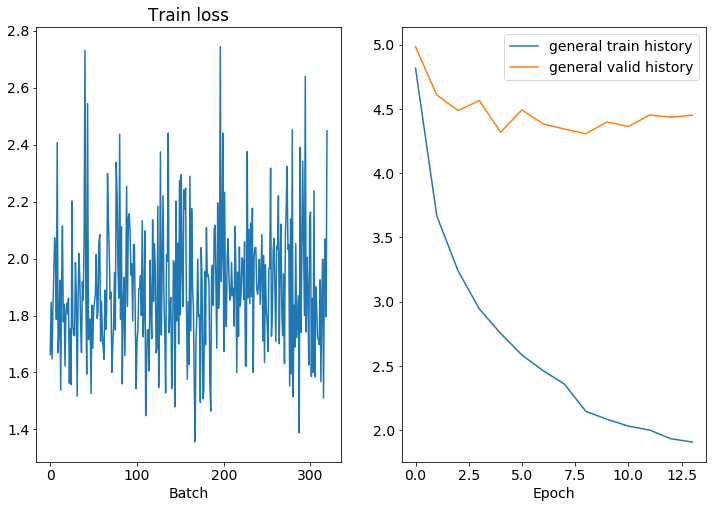

Epoch: 14
	Train Loss: 1.895 | Train PPL:   6.652
	 Val. Loss: 4.454 |  Val. PPL:  85.928
Training complete in 48m 9s
Best val Acc: 4.306460


55895

In [21]:
model_attpe = train_model(model_attpe, {"train":train_iterator,"valid":valid_iterator}, optimizer_attpe, criterion_attpe, scheduler_attpe, n_epochs=15,  clip=1, show_plots=True, nameModel="nmt_lstmAttentionPE.pth")
torch.cuda.empty_cache()
gc.collect()

In [22]:
#model_cnn = train_model(model_cnn, {"train":train_iterator,"valid":valid_iterator}, optimizer_cnn, criterion_cnn, n_epochs=2,  clip=1, show_plots=True, nameModel="nmt_cnnlstm.pth")
torch.cuda.empty_cache()
gc.collect()

20

__Let's take a look at our network quality__:

#### load model (probability - for correct work need save and datasets)

In [41]:
models = {"Attention + PE (epoch 15)": model_attpe,"Attention + PE (epoch9)": model_epoch8,"Attention + PE (epoch5)": model_epoch4,"Attention + PE (epoch3)": model_epoch2,"Attention + PE (epoch2)": model_epoch1,"Attention + PE (epoch1)": model_epoch0}

In [42]:
#del utils

#import utils
#import imp
#imp.reload(utils)
#generate_translation = utils.generate_translation
#remove_tech_tokens = utils.remove_tech_tokens
#get_text = utils.get_text
#flatten = utils.flatten

In [43]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm
#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

for name in models:
    #test translate
    print("MODEL:{}\nEXAMPLE TRANSLATE:\n".format(name))
    batch = next(iter(test_iterator))
    for idx in [1,2]:
        src = batch.src[:, idx:idx+1]
        trg = batch.trg[:, idx:idx+1]
        print(generate_translation(src, trg, models[name], TRG.vocab))
        
    original_text = []
    generated_text = []
    models[name].eval()
    with torch.no_grad():

        for i, batch in tqdm.tqdm(enumerate(test_iterator)):

            src = batch.src
            trg = batch.trg

            output = models[name](src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

    # original_text = flatten(original_text)
    # generated_text = flatten(generated_text)
    print(corpus_bleu([[text] for text in original_text], generated_text) * 100)

2it [00:00, 16.34it/s]

MODEL:Attention + PE (epoch 15)
EXAMPLE TRANSLATE:

Original: florence is 29 km away .
Generated: is is 63 km from the property .

None
Original: free private parking is available on site .
Generated: free private parking is available on site .

None


63it [00:06, 10.50it/s]
2it [00:00, 19.95it/s]

30.455288004536733
MODEL:Attention + PE (epoch9)
EXAMPLE TRANSLATE:

Original: florence is 29 km away .
Generated: is is 63 km from the property .

None
Original: free private parking is available on site .
Generated: free private parking is available on site .

None


63it [00:05, 10.51it/s]
2it [00:00, 17.26it/s]

30.455288004536733
MODEL:Attention + PE (epoch5)
EXAMPLE TRANSLATE:

Original: florence is 29 km away .
Generated: pula is 29 km from the property .

None
Original: free private parking is available on site .
Generated: free private parking is available on site .

None


63it [00:05, 10.55it/s]
2it [00:00, 18.13it/s]

24.55244328747141
MODEL:Attention + PE (epoch3)
EXAMPLE TRANSLATE:

Original: florence is 29 km away .
Generated: the property is located km from the property .

None
Original: free private parking is available on site .
Generated: free private parking is available on site .

None


63it [00:06, 10.14it/s]
2it [00:00, 19.95it/s]

19.886624860870654
MODEL:Attention + PE (epoch2)
EXAMPLE TRANSLATE:

Original: florence is 29 km away .
Generated: the property is located km from the property .

None
Original: free private parking is available on site .
Generated: free private parking is available .

None


63it [00:05, 10.53it/s]
2it [00:00, 17.14it/s]

14.936341507711678
MODEL:Attention + PE (epoch1)
EXAMPLE TRANSLATE:

Original: florence is 29 km away .
Generated: is is km from the property .

None
Original: free private parking is available on site .
Generated: free parking is available on site .

None


63it [00:06, 10.39it/s]


9.13350349013508


In [27]:
#corpus_bleu([[text] for text in original_text], generated_text) * 100

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points